###Introduction of Logistic Regression

**What is Logistic Regression?**

Logistic regression is a supervised learning algorithm used to predict a dependent categorical target variable. In essence, if you have a large set of data that you want to categorize, logistic regression may be able to help. (https://www.mastersindatascience.org/learning/machine-learning-algorithms/logistic-regression/)

**Type of Logistic Regression**
1. Binary logistic regression
* This algorithm compute the input $X$ into output $y$, where $y$ only means true or false.
* $y\in \{0,1\}$
* e.g. Is this picture has a dog? etc.
2. Multinomial logistic regression
* e.g.
* Classifying texts into what language they come from.
* Predicting whether a student will go to college, trade school or into the workforce.
* Does your cat prefer wet food, dry food or human food?
* etc.
3. Ordinal logistic regression
* Ordinal logistic regression is also a model where there are multiple classes that an item can be classified as; however, in this case an ordering of classes is required. Classes do not need to be proportionate. The distance between each class can vary.
* e.g. Movies Rate etc.

reference: https://www.mastersindatascience.org/learning/machine-learning-algorithms/logistic-regression/

**Why we do not use linear regression in this case?**

Linear Regression can only be used for predicting the relationship between continuous variable.

This algorithm is not good for classification task because
* In this case, output data can be classify into 2 values $\{0,1\}$, the linear regression algorithmn do not predict output data accuratly at all.
* In theory, $h(x)$ should be $0\leq h(x)\leq 1$ for boolean classification problem.

**What I will do in this tutorial?**
* I will demonstrate how to use Logistic Regression to predict the relationship between discrete $x$ variable and discrete $y$ variable.

**Step**
1. Get Data
2. Creating Hypothesis Function
3. Interpret the result

**Note**
* Both linear regression and logistic regression are linear model.

###Step 1, Getting Data

**(1.) Import Data**

In [2]:
!pip install --upgrade -q gspread

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 KB 816.9 kB/s eta 0:00:00


In [3]:
# [1.] import library

from __future__ import absolute_import, division, print_function, unicode_literals

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math 

# [2.] Connect Google Collab with Google Sheet
from google.colab import auth
import gspread
from google.auth import default
from google.colab import data_table

auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)
worksheet = gc.open('student-mat').get_worksheet(0)
rows = worksheet.get_all_values()
dfmain = pd.DataFrame(rows)

# [3.] Display Data form Google Sheet
dfmain.head()

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
1,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
2,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
3,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
4,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15


**(2.) Clean Data**

Now we have the data. However we have to reorganize (clean) the data before analyse the data, because computer cannot analyse string data type. In addition, cleaning data help us analyse data more easily.

In [4]:
# [1.] Get string from the first row of every columns
# reference: https://www.easytweaks.com/get-first-row-pandas-dataframe/
ColumnName = dfmain.iloc[0].to_list()

# [2.] Rename every column
for i in range(len(ColumnName)):
  ColumnName[i]=ColumnName[i]+'_'+str(i)
  dfmain.rename(columns={i:ColumnName[i]},inplace=True)

# [3.] Drop first row
dfmain=dfmain.drop([0], axis=0)

# [4.] Change Data Type
# reference: https://www.geeksforgeeks.org/change-data-type-for-one-or-more-columns-in-pandas-dataframe/
# reference: https://statisticsglobe.com/convert-string-boolean-pandas-dataframe-column-python
# reference: https://sparkbyexamples.com/pandas/pandas-convert-column-to-numpy-array/
# reference: https://pandas.pydata.org/docs/reference/api/pandas.Series.map.html
# reference: https://stackoverflow.com/questions/2468334/creating-dynamic-and-expandable-dictionaries-in-python
# reference: https://favtutor.com/blogs/merge-dictionaries-python
# reference: https://datagy.io/python-int-to-binary/

# VectorName is used for indicate the meaning of the vector in each categorized data based column
# VectorName = [[ColumnIndex,ColumnDict],...,[ColumnIndex,ColumnDict]]
VectorName=[]

# BinaryVector(lengh) is a function that is used for generate vector
def BinaryVector(lengh):
  mathbbR = math.ceil(math.log2(lengh))
  categorization = []
  for element in range(lengh):
    binary = str(bin(element)).split('b')[1]
    vector = []
    for k in range(mathbbR-len(binary)):
      vector.append(0)
    for i in binary:
      vector.append(int(i))
    categorization.append(vector)
  categorization=np.array(categorization)
  return categorization

# Change the data type of every column in dfmain
for i in range(len(ColumnName)):
  IsD=np.array(dfmain[ColumnName[i]])[0]
  if IsD.isdigit():
    # Change data type from String into Integer
    dfmain[ColumnName[i]]=dfmain[ColumnName[i]].apply(pd.to_numeric)
  else:
    # Change data type from String into Vector that contains 0 and 1
    dfColumn = dfmain[ColumnName[i]].to_numpy()
    ListValue=list(np.sort(pd.Series(np.array(dfColumn)).value_counts().index.to_numpy()))
    # Create Binary Vecotr Dictionary
    Convert = { "data":[]}
    Category=BinaryVector(len(ListValue))
    for j in range(len(ListValue)):
      ConvertData = {}
      ConvertData[ListValue[j]] = Category[j]
      Convert["data"].append(ConvertData)
    for k in range(len(Convert['data'])):
      if (k!=0):
        Convert['data'][k].update(Convert['data'][k-1])
      else:
        continue
    # Update the dfmain and VectorName
    VectorName.append([i,Convert['data'][-1]])
    dfmain[ColumnName[i]] = dfmain[ColumnName[i]].map(dict(Convert['data'][-1]))

In [ ]:
dfmain.head()

###Step 2.1, Why Logistic Regression for continuous variables is not effective for discrete input variable?

**Initial variable**

Given that:
* $x\in\mathbb{Z},x\in[0,1]$
* $y\in\mathbb{Z},y\in[0,1]$


In [ ]:
ind_X=22
ind_Y=20
ColumnNameX=ColumnName[ind_X]
ColumnNameY=ColumnName[ind_Y]
dfmain=dfmain

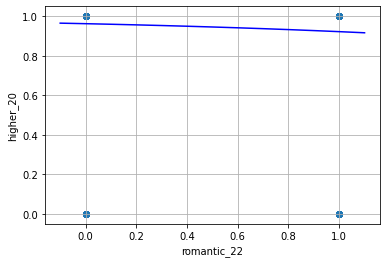

h_i[1] = [-0.7767415]
h_i[0] = [3.25426529]


'\nNote: I got h_i = [1.32865499 0.17638434]\n'

In [78]:
from sklearn import linear_model

ind_X=22
ind_Y=20
ColumnNameX=ColumnName[ind_X]
ColumnNameY=ColumnName[ind_Y]
dfmain=dfmain

dfmain_X = np.stack(list(np.array(dfmain[ColumnNameX]))).reshape(-1)
dfmain_Y = np.stack(list(np.array(dfmain[ColumnNameY]))).reshape(-1)

logr = linear_model.LogisticRegression()
logr.fit(np.array(dfmain_X).reshape(-1,1),dfmain_Y)

predicted = logr.predict(np.array([-40]).reshape(-1,1))

def HypothesisFunction(x,logr):
  probability = 1 / (1 + np.exp(-(logr.coef_ * x + logr.intercept_)))
  '''
  Note:
  * logr.coef_ = h_i[1]
  * logr.intercept_ = h_i[0]
  '''
  return(probability.reshape(-1))

# [3.] Plot the Graph
plt.grid()

plt.xlabel(ColumnNameX)
plt.ylabel(ColumnNameY)
plt.scatter(dfmain[ColumnNameX], dfmain[ColumnNameY])
xline = np.arange(-0.1,1.1,0.1)
yline = HypothesisFunction(xline,logr)

plt.plot(xline, yline, color='blue')
plt.show()

print('h_i[1] = '+str(logr.coef_[0]))
print('h_i[0] = '+str(logr.intercept_))

'''
Note: I got h_i = [1.32865499 0.17638434]
'''

In [79]:
FF = len(dfmain.loc[(dfmain[ColumnNameX] == 0)& (dfmain[ColumnNameY] == 0)])
FT = len(dfmain.loc[(dfmain[ColumnNameX] == 0)& (dfmain[ColumnNameY] == 1)])
TF = len(dfmain.loc[(dfmain[ColumnNameX] == 1)& (dfmain[ColumnNameY] == 0)])
TT = len(dfmain.loc[(dfmain[ColumnNameX] == 1)& (dfmain[ColumnNameY] == 1)])

print("FF = "+str(FF))
print("FT = "+str(FT))
print("TF = "+str(TF))
print("TT = "+str(TT))

FF = 9
FT = 254
TF = 11
TT = 121


###Step 2.2, Modify logistic regression for discrete input variable

In [39]:
ind_X=20
ind_Y=32
ColumnNameX=ColumnName[ind_X]
ColumnNameY=ColumnName[ind_Y]
dfmain=dfmain

**What is T Test?**
* A statistical test that is used to compare the means of two groups.

**T Test Formula:** $y_{\text{test}}=\text{mean}_{0}*B_0+(\text{mean}_{1}-\text{mean}_{0})*B_1=\text{mean}_{0}*B_0+\Delta\text{mean}*B_1$

* $y_{\text{test}}=$ T Test result
* $\text{mean}_0=$ average value of $y$ when $x=0$
* $\text{mean}_1=$ average value of $y$ when $x=1$
* $B_0=$ coefficient that turn on $\text{mean}_{0}$
* $B_1=$ coefficient that turn off or on $\text{mean}_{1}$ depending on the data

**Note**
* The blue line = $\text{mean}_0$
* The red line = $\text{mean}_1=\text{mean}_0+\Delta\text{mean}*B_1$

**T Test in Matrix Form**
* The data can be represented as matrix
* $y_{\text{test}}=\begin{bmatrix}
\text{mean}_{0}*\vec{B_0} & (\text{mean}_{1}-\text{mean}_{0})*\vec{B_1}\\
\end{bmatrix}\in\mathbb{R}^{m\times2}$
* $\vec{B_0},\vec{B_1}\in\mathbb{R}^m,m=$ number of all data $\in\mathbb{Z}^+$

**Why doing this?**
* We are testing if $\text{mean}_{1}-\text{mean}_{0}=0$ or not?
* If $\text{mean}_{1}-\text{mean}_{0}=0\implies$ your data matches the null hypothesis and there are no irregularities found.
* null hypothesis = The hypothesis that there is no significant difference between specified populations, any observed difference being due to sampling or experimental error.

mean0 = 6.8
mean1 = 10.608


<ipython-input-40-b7982ba8884e>:23: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(line,(line/line)*dfmain.loc[dfmain[ColumnNameX] == 0, ColumnNameY].mean(),color='blue')
<ipython-input-40-b7982ba8884e>:25: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(line,(line/line)*dfmain.loc[dfmain[ColumnNameX] == 1, ColumnNameY].mean(),color='red')


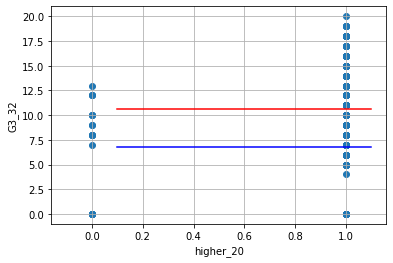

In [40]:
def HypothesisFunction(x1,h0,h1):
  return 1/(1+np.exp(-(x1*h1+h0)))

def EvaluationFunction(data,ind_x,ind_y,h0=0,h1=0):
  num=0
  for i in range(data.shape[0]):
    num-=data.iat[i,ind_y]*np.emath.log(HypothesisFunction(data.iat[i,ind_x],h0,h1))+(1-data.iat[i,ind_y])*np.emath.log(1-HypothesisFunction(data.iat[i,ind_x],h0,h1))
  num*=(1/data.shape[0])
  return num

plt.grid()

# The Data
plt.xlabel(ColumnNameX)
plt.ylabel(ColumnNameY)
plt.scatter(dfmain[ColumnNameX], dfmain[ColumnNameY])

# The mean of the data
line=np.arange(-0.1,1.1,0.1)
mean0 = dfmain.loc[dfmain[ColumnNameX] == 0, ColumnNameY].mean()
mean1 = dfmain.loc[dfmain[ColumnNameX] == 1, ColumnNameY].mean()
print('mean0 = '+str(mean0))
plt.plot(line,(line/line)*dfmain.loc[dfmain[ColumnNameX] == 0, ColumnNameY].mean(),color='blue')
print('mean1 = '+str(mean1))
plt.plot(line,(line/line)*dfmain.loc[dfmain[ColumnNameX] == 1, ColumnNameY].mean(),color='red')

plt.show()

In [42]:
yTEST = pd.DataFrame(
    data={
        #'mean0': list(np.stack(list(mean0*np.ones(dfmain[ColumnNameX].shape[0])))), 
        #'mean1-mean0': list(np.stack(list((mean1-mean0)*dfmain[ColumnNameX])).reshape(-1)),
        'result':list(np.stack(list(mean0+(mean1-mean0)*dfmain[ColumnNameX])).reshape(-1))
        }
        )
                         
print(yTEST)     

     result
0    10.608
1    10.608
2    10.608
3    10.608
4    10.608
..      ...
390  10.608
391  10.608
392  10.608
393  10.608
394  10.608

[395 rows x 1 columns]


**What is Odds?**

Odds provide a measure of the likelihood of a particular outcome.

* Odds $=\frac{\text{probability that the outcome occurs}}{\text{the probability that the outcome does not occur}}=\frac{p}{1-p}$
* Odds is not probability
* Probability $=\frac{\text{probability that the outcome occurs}}{\text{total outcome}}=p\in[0,1]$

**What is $\ln(\frac{p}{1-p})$ used for?**
* $\ln(\frac{p}{1-p})=\ln(\text{Odds})$
* $\ln()$ makes odds becomes symmetrical.

reference: https://youtu.be/ARfXDSkQf1Y

**How to apply T Test with logistic regression formula that have discrete input variable?**

Given that:
* $y_{\text{test}}=$ T Test result

**The logistic regression formula with discrete input variable:** 
$y_{\text{test}}=B_1*\ln(\frac{F_T}{F_F})+B_2*(\ln(\frac{T_T}{T_F})-\ln(\frac{F_T}{F_F}))$
* $y_{\text{test}}=$ The Test that indicate the relationship between input and output variable.
* $F=0=$ False, $T=1=$ True
* $F_F=$ number of all $\vec{v}$ that $\begin{bmatrix} 0& 0 \end{bmatrix}$
* $F_T=$ number of all $\vec{v}$ that $\begin{bmatrix} 0& 1 \end{bmatrix}$
* $T_F=$ number of all $\vec{v}$ that $\begin{bmatrix} 1& 0 \end{bmatrix}$
* $T_T=$ number of all $\vec{v}$ that $\begin{bmatrix} 1& 1 \end{bmatrix}$
* $B_0=$ coefficient that turn on $\ln(\frac{F_T}{F_F})$
* $B_1=$ coefficient that turn off or on $(\ln(\frac{T_T}{T_F})-\ln(\frac{F_T}{F_F}))$ depending on the data

**Why $\ln(...)$?**
* $\ln(...)=\ln(\frac{p}{1-p})=\ln(\text{Odds})$

In [ ]:
ind_X=22
ind_Y=20
ColumnNameX=ColumnName[ind_X]
ColumnNameY=ColumnName[ind_Y]
dfmain=dfmain

In [74]:
FF = len(dfmain.loc[(dfmain[ColumnNameX] == 0)& (dfmain[ColumnNameY] == 0)])
FT = len(dfmain.loc[(dfmain[ColumnNameX] == 0)& (dfmain[ColumnNameY] == 1)])
TF = len(dfmain.loc[(dfmain[ColumnNameX] == 1)& (dfmain[ColumnNameY] == 0)])
TT = len(dfmain.loc[(dfmain[ColumnNameX] == 1)& (dfmain[ColumnNameY] == 1)])

print("FF = "+str(FF))
print("FT = "+str(FT))
print("TF = "+str(TF))
print("TT = "+str(TT))
# reference: https://stackoverflow.com/questions/17322109/get-dataframe-row-count-based-on-conditions

yTEST = pd.DataFrame(
    data={
        'X Variable':list(dfmain[ColumnNameX]),
        'Y Variable':list(dfmain[ColumnNameY]),
        'result':list(np.log((FT)/(FF))+(np.log((TT)/(TF))-np.log((FT)/(FF)))*dfmain[ColumnNameX])
        }
        )

print('np.log((FT)/(FF)) = '+str(np.log((FT)/(FF))))
print('np.log((TT)/(TF))-np.log((FT)/(FF)) = '+str(np.log((TT)/(TF))-np.log((FT)/(FF))))
print(yTEST)

FF = 9
FT = 254
TF = 11
TT = 121
np.log((FT)/(FF)) = 3.340109689682317
np.log((TT)/(TF))-np.log((FT)/(FF)) = -0.9422144168839464
    X Variable Y Variable                result
0          [0]        [1]   [3.340109689682317]
1          [0]        [1]   [3.340109689682317]
2          [0]        [1]   [3.340109689682317]
3          [1]        [1]  [2.3978952727983707]
4          [0]        [1]   [3.340109689682317]
..         ...        ...                   ...
390        [0]        [1]   [3.340109689682317]
391        [0]        [1]   [3.340109689682317]
392        [0]        [1]   [3.340109689682317]
393        [0]        [1]   [3.340109689682317]
394        [0]        [1]   [3.340109689682317]

[395 rows x 3 columns]


###Step 3, How to interpret the result

In [81]:
print('log(the Odds that [y=1] when [x=0]) = np.log((FT)/(FF)) = '+str(np.log((FT)/(FF))))
print('log(the Odds ratio) = np.log((TT)/(TF))-np.log((FT)/(FF)) = '+str(np.log((TT)/(TF))-np.log((FT)/(FF))))

'''
* log(the Odds ratio) = How much change probability of [y=1] the log scale that [x=1]
* If log(the Odds ratio) = 0, then if [x=0] the value of y is not change
'''

log(the Odds that [y=1] when [x=0]) = np.log((FT)/(FF)) = 3.340109689682317
log(the Odds that [y=1] when [x=1])  = np.log((TT)/(TF))-np.log((FT)/(FF)) = -0.9422144168839464


**To Do Now:** 
* Change the T Test result into probability percentange
* Explain Why Logistic Regression for continuous variables is not effective for discrete input variable?
* Operate this algorithm using SKLearn
* Other logistic regression algorithm tutorial
* linear regression using SKLearn
* linear regression and Logistic regression using tensorflow and Seaborn
* Neural Network Tutorial
* Other popular statistics tutorial e.g. standard deviation, p value etc.

###Reference:
* https://youtu.be/vN5cNN2-HWE